In [1]:
import sys

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../RD-systems-and-test-benches/utils")
import model_fsolve as modf
import model_fsolve_v2 as modf2

import scipy.optimize as sco
import scipy.interpolate as sci

import hx_hydraulic as hxhy
import from_excel as fe
import data_plots as dplt

import fluids as fds
from CoolProp.CoolProp import PropsSI

import openpyxl as opxl
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
import os
import plotly.graph_objects as go

import utils.data_processing as dp
import utils.conversion as conv

import copy

from tqdm import tqdm

from plot_config import *

In [2]:
df = pd.read_excel(r'G:\Drive partagés\Cercle Hard\R&D\Thèse VDE\Manuscrit\Chapter_PL\TUV_PL_results_V4.5_V4.6.xlsx', sheet_name = "V4.6_glycol")

df['Q'] = df['Vdot'].apply(lambda x: conv.convert_flow_rate(x, 'L/h', 'm3/s'))
df = df.loc[df['Vdot'] > 0]
df.sort_values(by = 'Vdot', inplace = True)
df.reset_index(drop = True, inplace = True)

# shortened
df = df.iloc[[0,1,2,5,8,11,13]]

In [3]:
path = r"G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Inputs"
file_name = "\V4.6_updated.xlsx"
hw, par, cond = fe.initialize(path, file_name)

fluid = {'name':'MPG','glycol_rate':0.4}
T_op = 23
p = 1

rho_op = PropsSI('D', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))
mu_op = PropsSI('V', 'T', conv.to_K(T_op), 'P', 1e5, hxhy.find_fluid(fluid))

fe.change_fluid(cond, fluid)
fe.change_temperature(cond, conv.to_K(T_op), fluid)

# tabl, res, PL, residuals = modf.PL_fsolve(par, cond) 

In [4]:
new_row = {
    'Vdot': 30,
    'mdot': conv.convert_flow_rate(30, 'L/h', 'kg/s', rho=rho_op),
    'PL': math.nan,
    'Q': conv.convert_flow_rate(30, 'L/h', 'm3/s')
}

df.loc[len(df)] = new_row
df.sort_values(by = 'Vdot', inplace = True)

df

,Vdot,mdot,PL,Q
7,30,0.008588,NaN,0.000008
0,88,0.025200,0.435,0.000024
1,100,0.028700,0.488,0.000028
2,149,0.042600,0.701,0.000041
5,236,0.067600,1.173,0.000066
8,341,0.097600,1.733,0.000095
11,429,0.123000,2.183,0.000119
13,503,0.144000,2.583,0.000140


In [5]:
D_tuy = 38.5e-3
A_tuy = math.pi * (D_tuy/2)**2
D_fit = 25e-3
A_fit = math.pi * (D_fit/2)**2
D_man = 35.4e-3
A_man = math.pi * (D_man/2)**2

bend_angle = 90
bend_radius = 40e-3 # m
L_unimpeded = 22.5e-3
L_linear_after_bend = (32 + 22.5) * 1e-3

In [6]:
df['inlet_first_contraction'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_tuy, Di2=D_fit, Re = fds.core.Reynolds(V=x/A_tuy, D=D_tuy, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_tuy))

df['inlet_bend_in_fitting'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K=fds.fittings.bend_rounded(Di=D_fit, angle=bend_angle, rc = bend_radius, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op),L_unimpeded=L_unimpeded),
                                                                            rho = rho_op,
                                                                            V = x/A_fit))

df['inlet_linear_after_bend'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.K_from_f(fds.friction.friction_factor(Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)), L=L_linear_after_bend, D=D_fit),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df['inlet_first_expansion'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.diffuser_sharp(Di1=D_fit, Di2=D_man, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df['before_hx'] = df['inlet_first_contraction'] + df['inlet_bend_in_fitting'] + df['inlet_linear_after_bend'] + df['inlet_first_expansion']

df['outlet_first_contraction'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.contraction_sharp(Di1=D_man, Di2=D_fit, Re = fds.core.Reynolds(V=x/A_man, D=D_man, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_man))
df['outlet_first_expansion'] = df['Q'].apply(lambda x : 1e-3 * fds.dP_from_K(K = fds.fittings.diffuser_sharp(Di1=D_fit, Di2=D_tuy, Re = fds.core.Reynolds(V=x/A_fit, D=D_fit, rho = rho_op, mu = mu_op)),
                                                                                rho = rho_op,
                                                                                V = x/A_fit))

df['before_hx'] = df['inlet_first_contraction'] + df['inlet_bend_in_fitting'] + df['inlet_linear_after_bend'] + df['inlet_first_expansion']
df['after_hx'] = df['outlet_first_contraction'] + df['inlet_bend_in_fitting'] + df['inlet_linear_after_bend'] + df['outlet_first_expansion']
df['both_singular'] = df['before_hx'] + df['after_hx']
df['singular_proportion'] = df['both_singular'] / df['PL']

In [7]:
res_dict = {}
PL_res = []

for Vdot in tqdm(df['Vdot'], total = len(df['Vdot'])):
    fe.change_Vdot(cond, Vdot)
    tabl, PL, df_PL, residuals = modf.PL_fsolve(par, cond)

    res_dict[Vdot] = {'tabl' : copy.deepcopy(tabl),
                      'PL' : PL,
                      'df_PL' : copy.deepcopy(df_PL),
                      'residuals' : copy.deepcopy(residuals)}

    PL_res.append(PL)

100%|██████████| 8/8 [00:41<00:00,  5.14s/it]


In [8]:
df['PL_hx_model'] = np.array(PL_res)/1000
df['PL_tot_model'] = df['PL_hx_model'] + df['both_singular']

df['ratio'] = df['PL_tot_model'] / df['PL']

In [9]:
df

,Vdot,mdot,PL,Q,inlet_first_contraction,inlet_bend_in_fitting,inlet_linear_after_bend,inlet_first_expansion,before_hx,outlet_first_contraction,outlet_first_expansion,after_hx,both_singular,singular_proportion,PL_hx_model,PL_tot_model,ratio
7,30,0.008588,NaN,0.000008,0.000011,0.000204,0.000184,0.000037,0.000436,0.000013,0.000050,0.000450,0.000886,NaN,0.179298,0.180184,NaN
0,88,0.025200,0.435,0.000024,0.000091,0.001099,0.000538,0.000321,0.002049,0.000109,0.000427,0.002174,0.004223,0.009707,0.526283,0.530506,1.219553
1,100,0.028700,0.488,0.000028,0.000117,0.001351,0.000612,0.000415,0.002494,0.000141,0.000552,0.002656,0.005150,0.010553,0.598129,0.603279,1.236228
2,149,0.042600,0.701,0.000041,0.000260,0.002592,0.000912,0.000920,0.004685,0.000314,0.001225,0.005043,0.009728,0.013877,0.891701,0.901428,1.285918
5,236,0.067600,1.173,0.000066,0.000653,0.005573,0.001444,0.002309,0.009979,0.000787,0.003074,0.010878,0.020857,0.017781,1.413732,1.434590,1.223009
8,341,0.097600,1.733,0.000095,0.001363,0.010381,0.002086,0.004821,0.018651,0.001643,0.006418,0.020528,0.039180,0.022608,2.045120,2.084300,1.202712
11,429,0.123000,2.183,0.000119,0.002157,0.015361,0.002625,0.007630,0.027774,0.002601,0.010157,0.030745,0.058518,0.026806,2.575422,2.633941,1.206569
13,503,0.144000,2.583,0.000140,0.002966,0.020189,0.003077,0.010490,0.036722,0.003576,0.013964,0.040806,0.077528,0.030015,3.022162,3.099690,1.200035


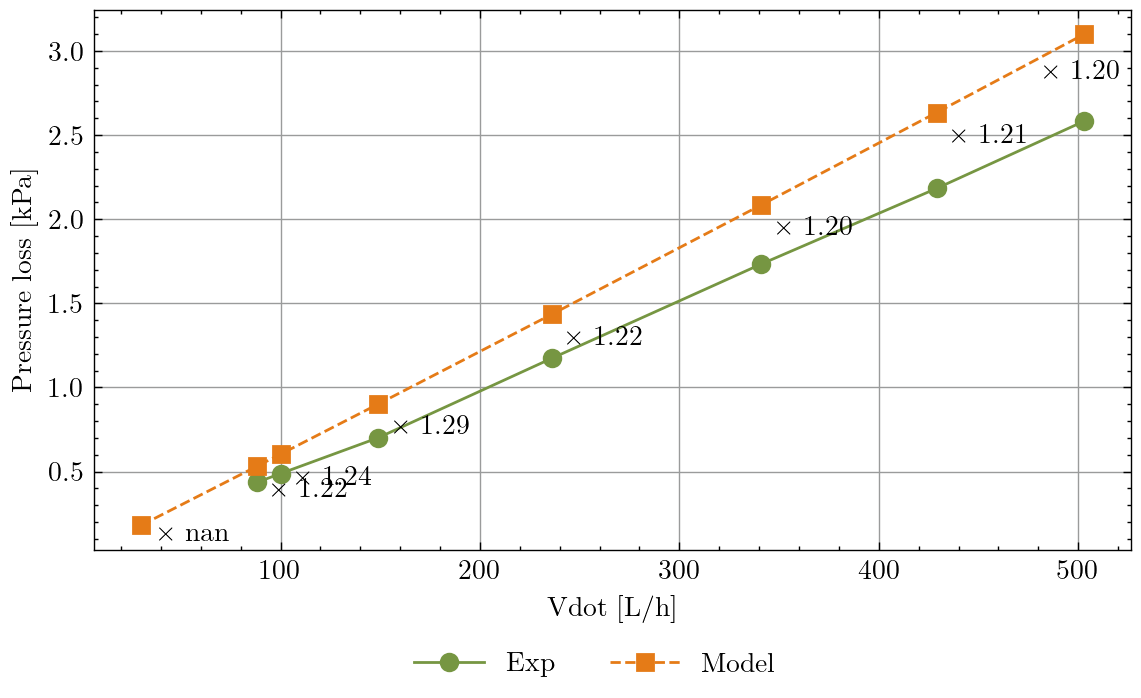

In [10]:
# Assuming rconfig.wcol_in and rconfig.hfig are defined correctly in your setup
fig, ax1 = plt.subplots(figsize=(rconfig.wcol_in, rconfig.hfig(0.3, unit="in")))

ax1.plot(df['Vdot'], df['PL'], label='Exp',
                                            color=colors[0],
                                            linestyle=linestyles[0],
                                            marker=markers[0],
)

# Scatter plot with Model and Experimental data
ax1.plot(df['Vdot'], df['PL_tot_model'], label='Model',
                                                    color=colors[1],
                                                    linestyle=linestyles[1],
                                                    marker=markers[1],
)   

# Annotate each model data point with the ratio of PL / PL_tot_model
for i, (x, y, ratio) in enumerate(zip(df['Vdot'], df['PL_tot_model'], df['ratio'])):
    if i == 0:
        x_pos, y_pos = 20, -5
    elif i == len(df['Vdot']) - 1:
        x_pos, y_pos = 0, -15
    else:
        x_pos, y_pos = 20, -10
    ax1.annotate(rf"$\times$ {ratio:.2f}", (x, y), textcoords="offset points", xytext=(x_pos, y_pos), ha='center')

# Customizing grid and adding legend
ax1.grid(linewidth=0.5, color=rconfig.get_hex_code('grey', 70))
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0.), ncol=2, frameon=False, handlelength=2.5)

ax1.set_xlabel('Vdot [L/h]')
ax1.set_ylabel('Pressure loss [kPa]')

# Show the plot
plt.show()


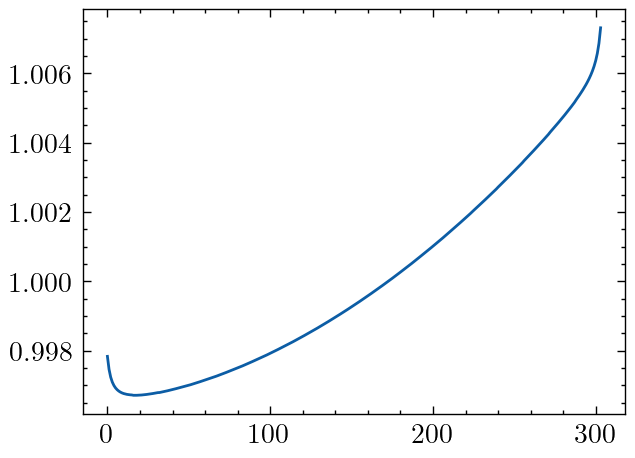

In [11]:
plt.plot(tabl.index, tabl['qx']/(tabl['qx'].sum()/304))

In [12]:
fig.savefig(r'G:\Mon Drive\GitHub\VDE_thesis\image\Chapter_PL\PL_V4.6_TUV_vs_1D.png', dpi=600)

In [13]:
dp.write_pickle(r'G:\Drive partagés\Cercle Hard\R&D\Modèles numériques PVT\PVT-PL-model\Thesis\1D_CFD_TUV','V4.6_1D_simple', df)